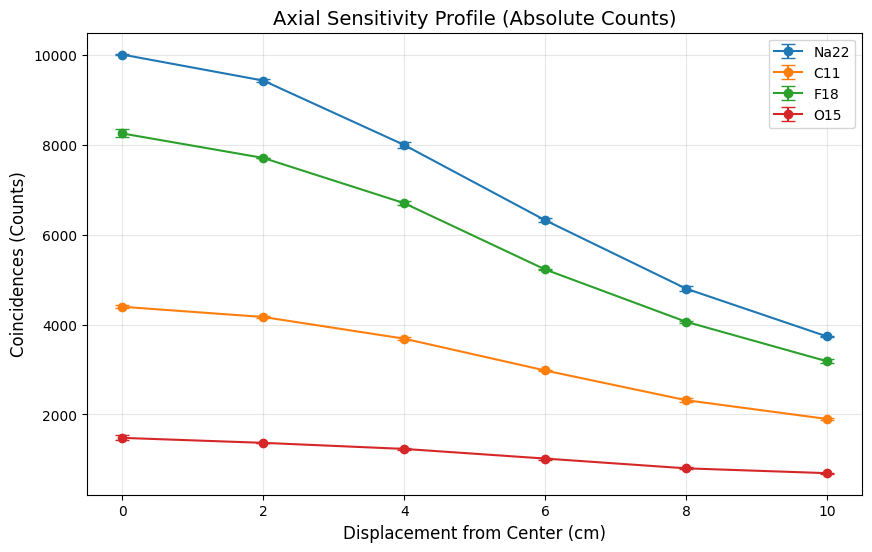

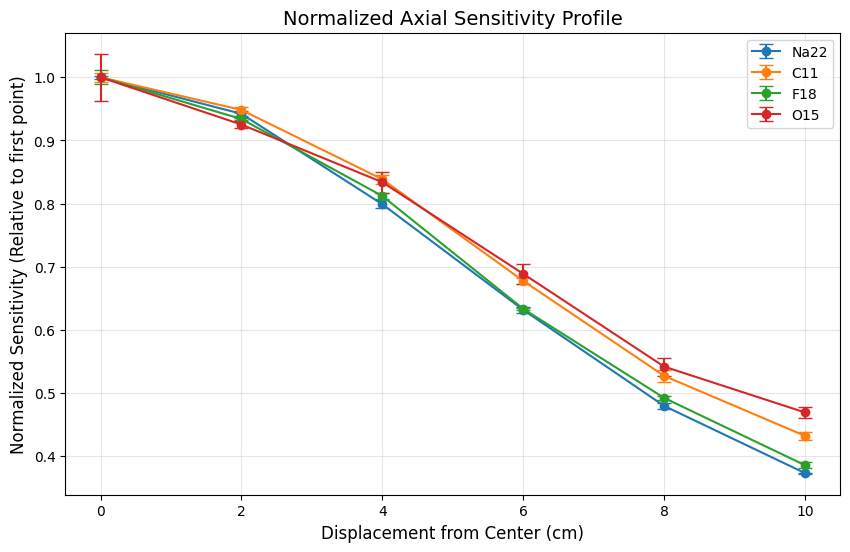

--- Individual FWHM Results ---
Na22: 16.78 +/- 0.03 cm
C11: 17.43 +/- 0.12 cm
F18: 15.84 +/- 0.05 cm
O15: 19.24 +/- 0.24 cm

--- COMBINED SYSTEM METRIC ---
Mean FWHM: 17.32 +/- 0.72 cm


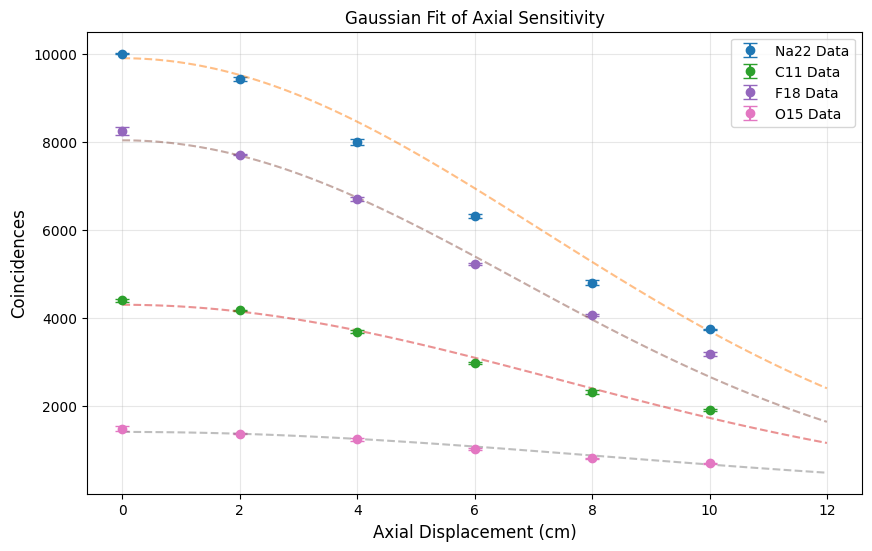

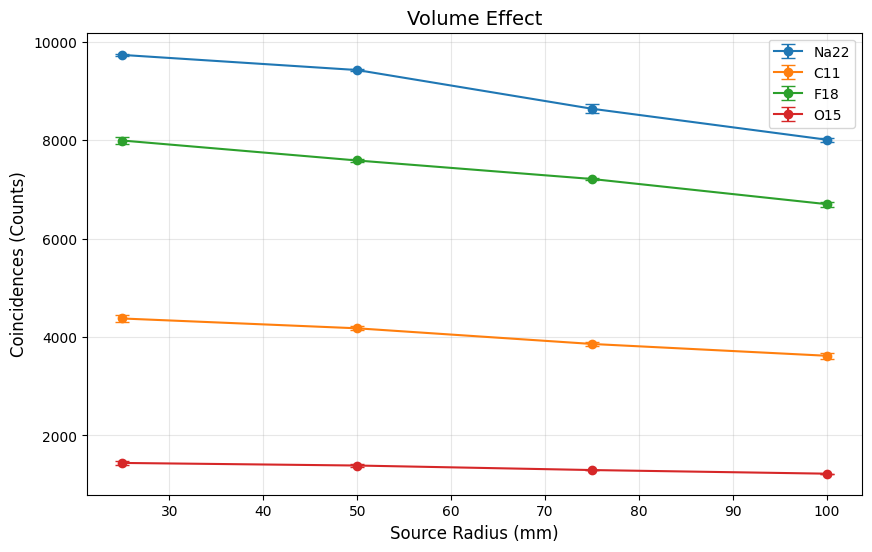

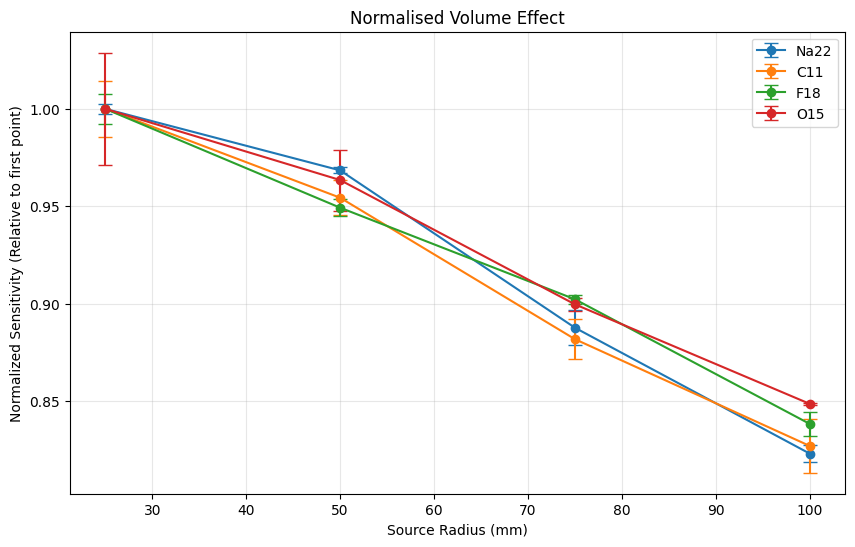

Signal drops by 2.25% +/- 0.14% per cm radius


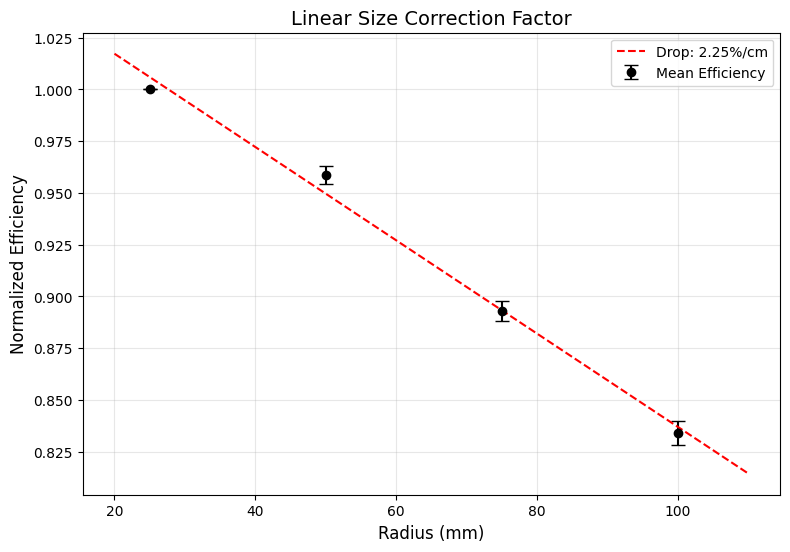

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

filename = 'Book1.csv'
delimiter = ';'

#loading data
df_disp = pd.read_csv(filename, sep=delimiter, nrows=4, usecols=range(19))
df_disp.columns = ['Isotope'] + [f"{d}cm_{i+1}" for d in [0,2,4,6,8,10] for i in range(3)]

#loading data
df_vol = pd.read_csv(filename, sep=delimiter, skiprows=6, nrows=4, usecols=range(13))
df_vol.columns = ['Isotope'] + [f"{r}mm_{i+1}" for r in [25,50,75,100] for i in range(3)]

#stats function
def calculate_stats(df, x_labels, run_count=3):
    stats = {}
    for _, row in df.iterrows():
        iso = row['Isotope']
        means = []
        sems = []
        for label in x_labels:
            cols = [f"{label}_{i+1}" for i in range(run_count)]
            values = row[cols].astype(float).values
            means.append(np.mean(values))
            sems.append(np.std(values, ddof=1) / np.sqrt(len(values)))
        stats[iso] = pd.DataFrame({'mean': means, 'sem': sems}, index=x_labels)
    return stats

#process Stats
disp_values = [0, 2, 4, 6, 8, 10]
stats_disp = calculate_stats(df_disp, ['0cm', '2cm', '4cm', '6cm', '8cm', '10cm'])

vol_values = [25, 50, 75, 100]
stats_vol = calculate_stats(df_vol, ['25mm', '50mm', '75mm', '100mm'])


#function plotting
def plot_absolute(stats_dict, x_values, x_label, y_label, title):
    plt.figure(figsize=(10, 6))
    for iso, df in stats_dict.items():
        plt.errorbar(x_values, df['mean'], yerr=df['sem'], fmt='-o', capsize=5, label=iso)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

def plot_normalized(stats_dict, x_values, x_label, y_label, title):
    plt.figure(figsize=(10, 6))
    for iso, df in stats_dict.items():
        norm_factor = df['mean'].iloc[0]
        norm_val = df['mean'] / norm_factor
        norm_err = df['sem'] / norm_factor
        plt.errorbar(x_values, norm_val, yerr=norm_err, fmt='-o', capsize=5, label=iso)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

#gaussian fit function
def gaussian(x, a, sigma):
    return a * np.exp(-(x)**2 / (2 * sigma**2))

def plot_gaussian_fit_with_errors(stats_dict, x_values):
    x_smooth = np.linspace(0, 12, 100)
    fwhm_results = []
    fwhm_errors = []

    print("--- Individual FWHM Results ---")
    plt.figure(figsize=(10, 6))
    
    for iso, df in stats_dict.items():
        y_data = df['mean'].values
        y_err = df['sem'].values
        popt, pcov = curve_fit(gaussian, x_values, y_data, p0=[max(y_data), 5], 
                                   sigma=y_err, absolute_sigma=True)
            
        sigma_val = abs(popt[1])
        sigma_err = np.sqrt(np.diag(pcov))[1]
        k = 2 * np.sqrt(2 * np.log(2))
            
        fwhm = k * sigma_val
        fwhm_err = k * sigma_err
            
        fwhm_results.append(fwhm)
        fwhm_errors.append(fwhm_err)
            
        print(f"{iso}: {fwhm:.2f} +/- {fwhm_err:.2f} cm")
            
        plt.errorbar(x_values, y_data, yerr=y_err, fmt='o', capsize=5, label=f"{iso} Data")
        plt.plot(x_smooth, gaussian(x_smooth, *popt), '--', alpha=0.5)
            


    #Combine all
    fwhm_results = np.array(fwhm_results)
    fwhm_errors = np.array(fwhm_errors)
    
    avg_fwhm = np.mean(fwhm_results)
    err_scatter = np.std(fwhm_results, ddof=1) / np.sqrt(len(fwhm_results))
    err_fit = np.sqrt(np.sum(fwhm_errors**2)) / len(fwhm_results)
    total_err = np.sqrt(err_scatter**2 + err_fit**2)
    
    print("\n--- COMBINED SYSTEM METRIC ---")
    print(f"Mean FWHM: {avg_fwhm:.2f} +/- {total_err:.2f} cm")
    
    plt.xlabel('Axial Displacement (cm)', fontsize=12)
    plt.ylabel('Coincidences', fontsize=12)
    plt.title(f'Gaussian Fit of Axial Sensitivity')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

#linear correction function
def calculate_linear_correction(stats_vol, x_values):
    normalized_curves = []
    
    for iso, df in stats_vol.items():
        means = df['mean'].values
        normalized_curves.append(means / means[0]) 
    
    normalized_curves = np.array(normalized_curves)
    
    #average stats
    avg_y = np.mean(normalized_curves, axis=0)
    sem_y = np.std(normalized_curves, axis=0, ddof=1) / np.sqrt(len(normalized_curves))
    
    #linear Fit
    def linear_model(x, m, c): return m * x + c
    
    popt, pcov = curve_fit(linear_model, x_values, avg_y)
    perr = np.sqrt(np.diag(pcov))
    
    slope, intercept = popt
    slope_err = perr[0]
    
    drop_cm = abs(slope) * 10
    drop_cm_err = slope_err * 10
    
  
    print(f"Signal drops by {drop_cm*100:.2f}% +/- {drop_cm_err*100:.2f}% per cm radius")
    
    #plotting all
    plt.figure(figsize=(9, 6))
    plt.errorbar(x_values, avg_y, yerr=sem_y, fmt='ko', capsize=5, label='Mean Efficiency')
    fit_x = np.linspace(20, 110, 100)
    plt.plot(fit_x, linear_model(fit_x, slope, intercept), 'r--', 
             label=f'Drop: {drop_cm*100:.2f}%/cm')

    plt.xlabel('Radius (mm)', fontsize=12)
    plt.ylabel('Normalized Efficiency', fontsize=12)
    plt.title('Linear Size Correction Factor', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

plot_absolute(stats_disp, disp_values, 
              x_label='Displacement from Center (cm)', 
              y_label='Coincidences (Counts)', 
              title='Axial Sensitivity Profile (Absolute Counts)')


plot_normalized(stats_disp, disp_values, 
                x_label='Displacement from Center (cm)', 
                y_label='Normalized Sensitivity (Relative to first point)', 
                title='Normalized Axial Sensitivity Profile')

plot_gaussian_fit_with_errors(stats_disp, disp_values)

plot_absolute(stats_vol, vol_values, 
              x_label='Source Radius (mm)', 
              y_label='Coincidences (Counts)', 
              title='Volume Effect')

plt.figure(figsize=(10, 6))

for iso, df in stats_vol.items():
    norm_factor = df['mean'].iloc[0]
    plt.errorbar(vol_values, df['mean']/norm_factor, yerr=df['sem']/norm_factor, 
                 fmt='-o', capsize=5, label=iso)

plt.xlabel('Source Radius (mm)')
plt.ylabel('Normalized Sensitivity (Relative to first point)')
plt.title('Normalised Volume Effect')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

calculate_linear_correction(stats_vol, vol_values)